In [1]:
!pip install opendatasets
import opendatasets as od

import pandas

od.download(
    "https://www.kaggle.com/datasets/thedevastator/rsicd-image-caption-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: harrish7
Your Kaggle Key: ··········


100%|██████████| 677M/677M [00:08<00:00, 81.0MB/s]


In [58]:
import pandas as pd

df = pd.read_csv('/content/rsicd-image-caption-dataset/train.csv')
df2 = pd.read_csv('/content/rsicd-image-caption-dataset/valid.csv')
df3 = pd.read_csv('/content/rsicd-image-caption-dataset/test.csv')


In [54]:
import csv

f = open('captions.txt','w')
writer = csv.writer(f)
for i in range(len(df)):
  data = [df['filename'][i],eval(df['captions'][i])[0].split('.')[0]]
  writer.writerow(data)


f = open('captions_valid.txt','w')
writer = csv.writer(f)
for i in range(len(df2)):
  data = [df2['filename'][i],eval(df2['captions'][i])[0].split('.')[0].replace(",","|")]
  writer.writerow(data)

f = open('captions_test.txt','w')
writer = csv.writer(f)
for i in range(len(df3)):
  data = [df3['filename'][i],eval(df3['captions'][i])[0].split('.')[0].replace(",","|")]
  writer.writerow(data)

for i in range(len(df3)):
  data = [df3['filename'][i],eval(df3['captions'][i])[0].split('.')[0].replace(",","|")]
  writer.writerow(data)


In [4]:
!mkdir rsicd_images

In [55]:
from PIL import Image
import io
import ast

for i in range(len(df)):
  filename = df['filename'][i]
  image = Image.open(io.BytesIO((ast.literal_eval(df['image'][i])['bytes'])))
  image.save(filename)

for i in range(len(df2)):
  filename = df2['filename'][i]
  image = Image.open(io.BytesIO((ast.literal_eval(df2['image'][i])['bytes'])))
  image.save(filename)

for i in range(len(df3)):
  filename = df3['filename'][i]
  image = Image.open(io.BytesIO((ast.literal_eval(df3['image'][i])['bytes'])))
  image.save(filename)

In [6]:
import re

def preprocess(text):
    try:
      text = text.lower()
      text = re.sub(r'[^\w\s]', '', text)
      text = re.sub('\s+', ' ', text)
      text = text.strip()
      text = '[start] ' + text + ' [end]'
      return text
    except:
      return ""

In [56]:
captions = pd.read_csv('/content/captions.txt')
captions_valid = pd.read_csv('/content/captions_valid.txt')
captions_test = pd.read_csv('/content/captions_test.txt')


In [57]:
captions_test[captions_test.columns[1]] = captions_test[captions_test.columns[1]].apply(preprocess)
captions_test.head()

,rsicd_images/airport_348.jpg,The airport is very large
0,rsicd_images/airport_349.jpg,[start] green grass on both sides of the runwa...
1,rsicd_images/airport_35.jpg,[start] theres a lot of bare ground around the...
2,rsicd_images/airport_350.jpg,[start] theres a lot of bare land near the air...
3,rsicd_images/airport_351.jpg,[start] the airport covers a large area and ha...
4,rsicd_images/airport_352.jpg,[start] a large number of aircraft were parked...


In [8]:
captions[captions.columns[1]] = captions[captions.columns[1]].apply(preprocess)
captions.head()

,rsicd_images/airport_1.jpg,Many aircraft are parked next to a long building in an airport
0,rsicd_images/airport_10.jpg,[start] some planes are parked in an airport [...
1,rsicd_images/airport_100.jpg,[start] many aircraft are parked in an airport...
2,rsicd_images/airport_101.jpg,[start] many aircraft are parked near a large ...
3,rsicd_images/airport_102.jpg,[start] several buildings and green trees are ...
4,rsicd_images/airport_103.jpg,[start] some green trees are near a large piec...


In [16]:
captions_valid[captions_valid.columns[1]] = captions_valid[captions_valid.columns[1]].apply(preprocess)
captions_valid.head()

,rsicd_images/airport_61.jpg,the asphalted and airport runways divide the field into several rounded rectangles arranged next to which buildings and a road are located
0,rsicd_images/airport_62.jpg,[start] start many white planes are parked at ...
1,rsicd_images/airport_63.jpg,[start] start a parking apron with an airplane...
2,rsicd_images/airport_64.jpg,[start] start a ploygon terminal is built betw...
3,rsicd_images/airport_65.jpg,[start] start the ploygon terminal is built ne...
4,rsicd_images/airport_66.jpg,[start] start the terminal built on the parkin...


In [17]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm

In [18]:
MAX_LENGTH = 40
VOCABULARY_SIZE = 10000
BATCH_SIZE = 32
BUFFER_SIZE = 1000
EMBEDDING_DIM = 512
UNITS = 512

In [19]:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,
    output_sequence_length=MAX_LENGTH)

tokenizer.adapt(captions[captions.columns[1]])

In [20]:
word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [25]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(captions[captions.columns[0]], captions[captions.columns[1]]):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

img_to_cap_vector_valid = collections.defaultdict(list)
for img, cap in zip(captions_valid[captions_valid.columns[0]], captions_valid[captions_valid.columns[1]]):
    img_to_cap_vector_valid[img].append(cap)

img_keys_valid = list(img_to_cap_vector_valid.keys())
random.shuffle(img_keys_valid)
slice_index = int(len(img_keys)*1)
img_name_train_keys, img_name_val_keys = (img_keys,
                                          img_keys_valid)

train_imgs = []
train_captions = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    train_imgs.extend([imgt] * capt_len)
    train_captions.extend(img_to_cap_vector[imgt])

val_imgs = []
val_captions = []
print(img_name_val_keys)
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector_valid[imgv])
    val_imgs.extend([imgv] * capv_len)
    val_captions.extend(img_to_cap_vector_valid[imgv])

['rsicd_images/river_9.jpg', 'rsicd_images/airport_74.jpg', 'rsicd_images/00791.jpg', 'rsicd_images/industrial_67.jpg', 'rsicd_images/mountain_95.jpg', 'rsicd_images/industrial_9.jpg', 'rsicd_images/mediumresidential_76.jpg', 'rsicd_images/center_87.jpg', 'rsicd_images/center_81.jpg', 'rsicd_images/resort_89.jpg', 'rsicd_images/farmland_73.jpg', 'rsicd_images/bridge_97.jpg', 'rsicd_images/parking_98.jpg', 'rsicd_images/river_88.jpg', 'rsicd_images/stadium_94.jpg', 'rsicd_images/pond_75.jpg', 'rsicd_images/square_91.jpg', 'rsicd_images/denseresidential_95.jpg', 'rsicd_images/00799.jpg', 'rsicd_images/mediumresidential_81.jpg', 'rsicd_images/stadium_73.jpg', 'rsicd_images/denseresidential_67.jpg', 'rsicd_images/square_93.jpg', 'rsicd_images/beach_86.jpg', 'rsicd_images/bridge_96.jpg', 'rsicd_images/pond_99.jpg', 'rsicd_images/resort_88.jpg', 'rsicd_images/denseresidential_70.jpg', 'rsicd_images/farmland_66.jpg', 'rsicd_images/meadow_8.jpg', 'rsicd_images/storagetanks_95.jpg', 'rsicd_imag

In [26]:
len(train_imgs), len(train_captions), len(val_imgs), len(val_captions)

(8733, 8733, 1062, 1062)

In [27]:
def load_data(img_path, caption):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = img / 255.
    caption = tokenizer(caption)
    return img, caption

In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))

train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [29]:
image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
    ]
)

In [30]:
def CNN_Encoder():
    inception_v3 = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet'
    )
    inception_v3.trainable = False

    output = inception_v3.output
    output = tf.keras.layers.Reshape(
        (-1, output.shape[-1]))(output)

    cnn_model = tf.keras.models.Model(inception_v3.input, output)
    return cnn_model

In [31]:
class TransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")


    def call(self, x, training):
        x = self.layer_norm_1(x)
        x = self.dense(x)

        attn_output = self.attention(
            query=x,
            value=x,
            key=x,
            attention_mask=None,
            training=training
        )

        x = self.layer_norm_2(x + attn_output)
        return x

In [32]:
class Embeddings(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embeddings = tf.keras.layers.Embedding(
            vocab_size, embed_dim)
        self.position_embeddings = tf.keras.layers.Embedding(
            max_len, embed_dim, input_shape=(None, max_len))


    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start=0, limit=length, delta=1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings

In [33]:
Embeddings(tokenizer.vocabulary_size(), EMBEDDING_DIM, MAX_LENGTH)(next(iter(train_dataset))[1]).shape

TensorShape([32, 40, 512])

In [34]:
class TransformerDecoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, num_heads):
        super().__init__()
        self.embedding = Embeddings(
            tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)

        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )

        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()

        self.ffn_layer_1 = tf.keras.layers.Dense(units, activation="relu")
        self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)

        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")

        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.dropout_2 = tf.keras.layers.Dropout(0.5)


    def call(self, input_ids, encoder_output, training, mask=None):
        embeddings = self.embedding(input_ids)

        combined_mask = None
        padding_mask = None

        if mask is not None:
            causal_mask = self.get_causal_attention_mask(embeddings)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=combined_mask,
            training=training
        )

        out_1 = self.layernorm_1(embeddings + attn_output_1)

        attn_output_2 = self.attention_2(
            query=out_1,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask,
            training=training
        )

        out_2 = self.layernorm_2(out_1 + attn_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

In [35]:
class ImageCaptioningModel(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")


    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)


    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(img_embed, training=True)
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]
        mask = (y_true != 0)
        y_pred = self.decoder(
            y_input, encoder_output, training=True, mask=mask
        )
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc


    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)

        img_embed = self.cnn_model(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(
                img_embed, captions
            )

        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}


    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [36]:
encoder = TransformerEncoderLayer(EMBEDDING_DIM, 1)
decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8)

cnn_model = CNN_Encoder()
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

87910968/87910968 [==============================] - 1s 0us/step


In [37]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=cross_entropy
)

In [63]:
history = caption_model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/30
273/273 [==============================] - 73s 263ms/step - loss: 1.6979 - acc: 0.5889 - val_loss: 5.9010 - val_acc: 0.3001
Epoch 2/30
273/273 [==============================] - 72s 260ms/step - loss: 1.6052 - acc: 0.6048 - val_loss: 6.0167 - val_acc: 0.3240
Epoch 3/30
273/273 [==============================] - 75s 265ms/step - loss: 1.5228 - acc: 0.6141 - val_loss: 5.8982 - val_acc: 0.3342
Epoch 4/30
273/273 [==============================] - 70s 250ms/step - loss: 1.4622 - acc: 0.6265 - val_loss: 6.0433 - val_acc: 0.3228
Epoch 5/30
273/273 [==============================] - 71s 251ms/step - loss: 1.3987 - acc: 0.6336 - val_loss: 6.1451 - val_acc: 0.3155
Epoch 6/30
273/273 [==============================] - 69s 249ms/step - loss: 1.3392 - acc: 0.6461 - val_loss: 6.2286 - val_acc: 0.3149


In [43]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = img / 255.
    return img


def generate_caption(img_path):
    img = load_image_from_path(img_path)
    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)

        pred_idx = np.argmax(pred[0, i, :])
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break

        y_inp += ' ' + pred_word

    y_inp = y_inp.replace('[start] ', '')
    return y_inp

In [60]:
def get_caption_model():
    encoder = TransformerEncoderLayer(EMBEDDING_DIM, 1)
    decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8)

    cnn_model = CNN_Encoder()

    caption_model = ImageCaptioningModel(
        cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=None,
    )

    def call_fn(batch, training):
        return batch

    caption_model.call = call_fn
    sample_x, sample_y = tf.random.normal((1, 299, 299, 3)), tf.zeros((1, 40))

    caption_model((sample_x, sample_y))

    sample_img_embed = caption_model.cnn_model(sample_x)
    sample_enc_out = caption_model.encoder(sample_img_embed, training=False)
    caption_model.decoder(sample_y, sample_enc_out, training=False)

    caption_model.load_weights('/content/Epoch_2.h5')

    return caption_model


In [61]:
caption_model = get_caption_model()

ValueError: Cannot assign value to variable ' transformer_decoder_layer_5/embeddings_6/embedding_12/embeddings:0': Shape mismatch.The variable shape (1751, 512), and the assigned value shape (1743, 512) are incompatible.

Predicted Captions 
 many buildings and some green trees are located in an industrial area
many buildings and some green trees are located in an industrial area
many buildings and some green trees are located in an industrial area
many buildings and some green trees are located in an industrial area



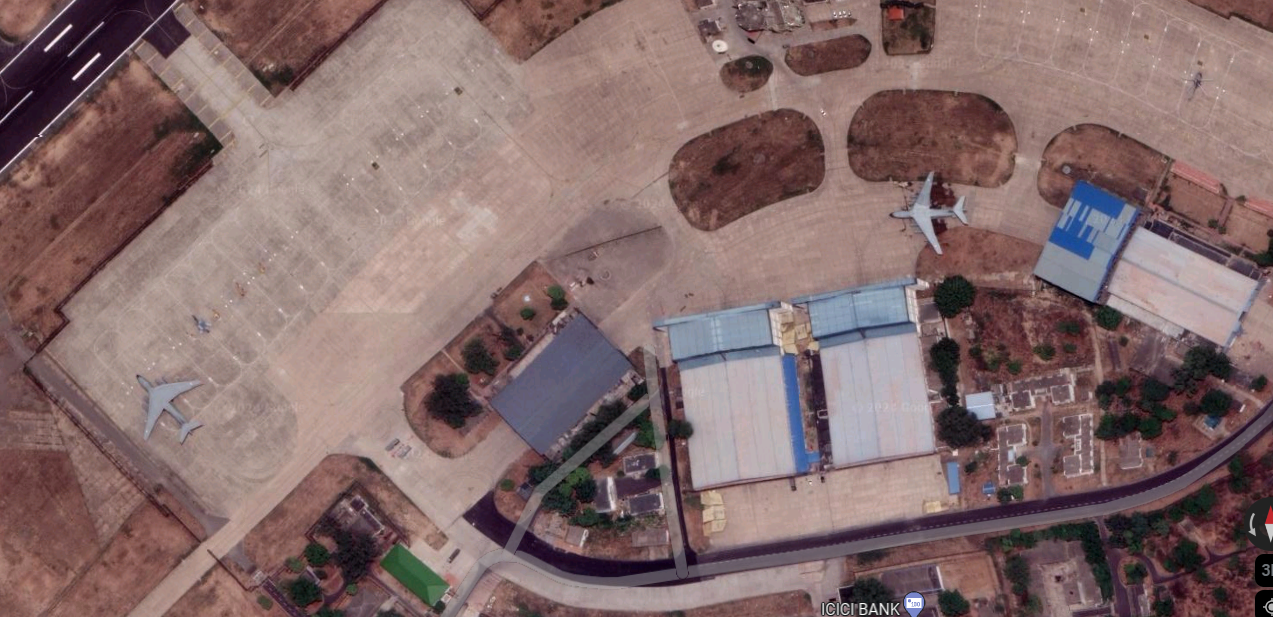

In [ ]:
idx = random.randrange(0, len(val_imgs))
img_path = "/content/test7.png"

pred_caption = generate_caption(img_path)
pred_caption1 = generate_caption(img_path)
pred_caption2 = generate_caption(img_path)
pred_caption3 = generate_caption(img_path)
print('Predicted Captions \n', pred_caption + "\n" + pred_caption1 + "\n" + pred_caption2 + "\n" + pred_caption3)
print()
Image.open(img_path)

Predicted Captions 
 many buildings and bare land are located in an industrial area



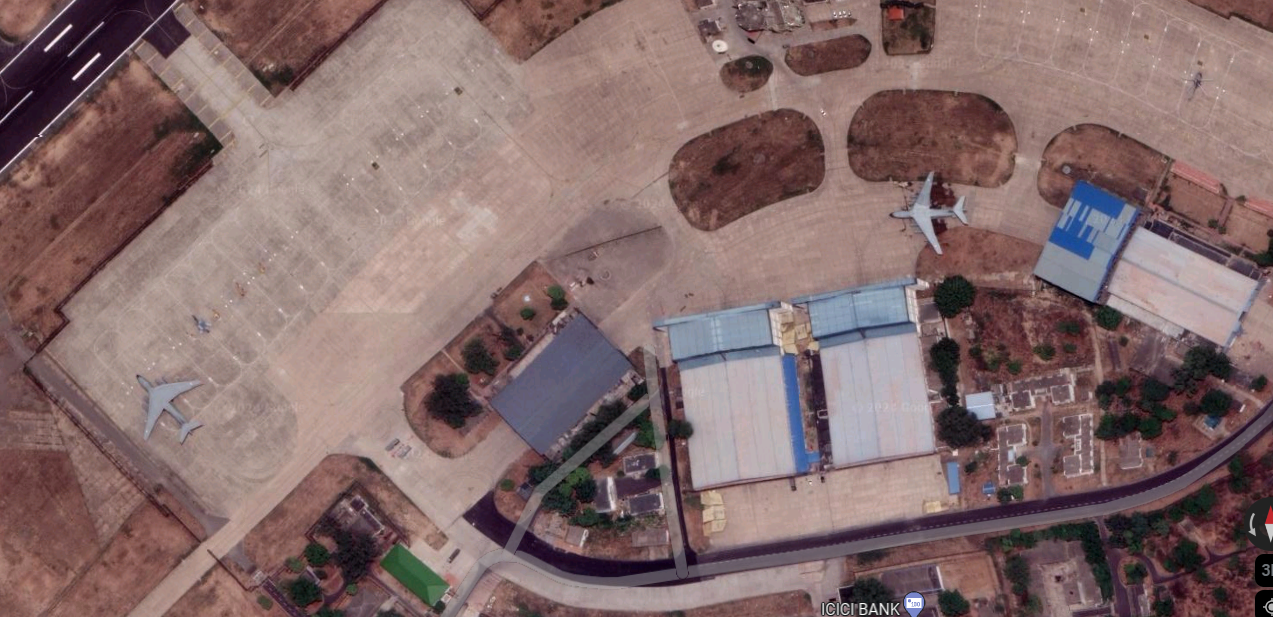

In [64]:
caption_model.save_weights("Epoch_V4.h5")

In [62]:
history = caption_model.fit(
    train_dataset,
    epochs=9,
    validation_data=val_dataset,
)

Epoch 1/9
273/273 [==============================] - 70s 246ms/step - loss: 2.1146 - acc: 0.5211 - val_loss: 5.5937 - val_acc: 0.3212
Epoch 2/9
273/273 [==============================] - 71s 255ms/step - loss: 1.8586 - acc: 0.5601 - val_loss: 5.7856 - val_acc: 0.3038
Epoch 3/9
 11/273 [>.............................] - ETA: 1:01 - loss: 1.8095 - acc: 0.5753

KeyboardInterrupt: 

In [ ]:
caption_model.save_weights("Epoch_V3_Overfit.h5")

In [65]:
from nltk.translate.bleu_score import sentence_bleu



reference = [
    eval(df3['captions'][6])[0].split('.')[0].split(),
    eval(df3['captions'][6])[0].split('.')[1].split(),
    eval(df3['captions'][6])[0].split('.')[3].split(),
    eval(df3['captions'][6])[0].split('.')[4].split(),
    eval(df3['captions'][6])[0].split('.')[2].split()
]

filename = df3['filename'][6]
predict = generate_caption(filename)
candidate = predict.split()
print('BLEU score -> {}'.format(sentence_bleu(reference, candidate )))


BLEU score -> 4.531969033464687e-78


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [66]:
import csv

f = open("valid.csv","w")
writer = csv.writer(f)
for i in range(len(df2)):
  filename = df2['filename'][i]
  predict = generate_caption(filename)
  writer.writerow([filename,predict])


In [67]:
import csv
from tqdm import tqdm
f = open("test.csv","w")
writer = csv.writer(f)
for i in tqdm(range(len(df3))):
  filename = df3['filename'][i]
  predict = generate_caption(filename)
  writer.writerow([filename,predict])

In [82]:
from nltk.translate.bleu_score import sentence_bleu

scored = 0

df4 = pd.read_csv("/content/valid.csv")

for id in range(len(df2)-1):
  reference = [
      eval(df2['captions'][id])[0].split('.')[0].split(),
      eval(df2['captions'][id])[0].split('.')[1].split(),
      eval(df2['captions'][id])[0].split('.')[3].split(),
      eval(df2['captions'][id])[0].split('.')[4].split(),
      eval(df2['captions'][id])[0].split('.')[2].split()
  ]
  try:
    filename = df2['filename'][id]
    predict = df4[df4.columns[1]][id]
    candidate = predict.split()
    score = sentence_bleu(reference, candidate,weights = (1,0,0,0))
    scored += score
  except:
    pass

print("Average BLEU score : ",scored/len(df2))


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Average BLEU score :  0.5927074156055537


In [83]:
from nltk.translate.bleu_score import sentence_bleu

scored = 0

df4 = pd.read_csv("/content/test.csv")

for id in range(len(df3)-1):
  reference = [
      eval(df3['captions'][id])[0].split('.')[0].split(),
      eval(df3['captions'][id])[0].split('.')[1].split(),
      eval(df3['captions'][id])[0].split('.')[3].split(),
      eval(df3['captions'][id])[0].split('.')[4].split(),
      eval(df3['captions'][id])[0].split('.')[2].split()
  ]
  try:
    filename = df3['filename'][id]
    predict = df4[df4.columns[1]][id]
    candidate = predict.split()
    score = sentence_bleu(reference, candidate,weights = (1,0,0,0))
    scored += score
  except:
    pass

print("Average BLEU score : ",scored/len(df2))


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Average BLEU score :  0.4758050892493352
